In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

#import lightgbm as lgb
import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

https://www.kaggle.com/mohammadkashifunique/tsp-single-xgboost-model

ver1

# Parameters

In [2]:
target = 'target'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 5
    N_ESTIMATORS = 20000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-oct-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")

In [5]:
train = train[train.columns[1:]]
test = test[test.columns[1:]]

# Preprocessing

In [6]:
features = [col for col in train.columns if 'f' in col]

In [7]:

train["std"] = train[features].std(axis=1)
train["min"] = train[features].min(axis=1)
train["max"] = train[features].max(axis=1)

test["std"] = test[features].std(axis=1)
test["min"] = test[features].min(axis=1)
test["max"] = test[features].max(axis=1)

features = features + ['std', 'min', 'max']

In [8]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float32) # for xgboost to run
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [9]:
train = reduce_memory_usage(train)
test  = reduce_memory_usage(test)

Mem. usage decreased to 970.84 Mb (56.0% reduction)
Mem. usage decreased to 484.94 Mb (55.9% reduction)


In [10]:
test[features]

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f278,f279,f280,f281,f282,f283,f284,std,min,max
0,0.178216,0.435617,0.010230,0.202074,0.390170,0.324221,0.221722,0.738894,0.582588,0.343770,...,0,0,0,1,1,1,0,0.282364,0.0,1.0
1,0.181250,0.476455,0.022413,0.283146,0.598020,0.349508,0.283467,0.721575,0.268990,0.208373,...,0,0,0,0,0,0,0,0.266328,0.0,1.0
2,0.159721,0.451202,0.259649,0.365274,0.594634,0.413502,0.249318,0.642339,0.411104,0.246891,...,0,0,0,1,0,0,0,0.285174,0.0,1.0
3,0.182424,0.520976,0.095344,0.327742,0.741830,0.358711,0.270077,0.601662,0.297742,0.252829,...,0,0,1,1,0,0,0,0.279020,0.0,1.0
4,0.229329,0.336513,0.023511,0.300913,0.668738,0.481586,0.545660,0.667849,0.546045,0.202731,...,0,1,0,0,1,0,0,0.277023,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.185473,0.525338,0.014945,0.204029,0.498957,0.431933,0.470553,0.731268,0.452134,0.211206,...,0,0,0,1,0,0,0,0.262592,0.0,1.0
499996,0.183194,0.553266,0.008055,0.280651,0.636591,0.478092,0.450386,0.582647,0.517270,0.225116,...,0,0,0,0,1,0,0,0.271275,0.0,1.0
499997,0.184650,0.533643,0.011218,0.201262,0.720698,0.472888,0.427469,0.589259,0.243879,0.413022,...,0,0,0,0,0,0,0,0.275204,0.0,1.0
499998,0.227731,0.513247,0.178603,0.313778,0.665656,0.401365,0.183369,0.708233,0.575135,0.152771,...,0,0,0,1,0,0,0,0.238888,0.0,1.0


In [11]:
train[target]

0         1
1         1
2         1
3         1
4         1
         ..
999995    1
999996    0
999997    0
999998    1
999999    0
Name: target, Length: 1000000, dtype: int8

In [12]:
gc.collect()

40

# XGB

In [13]:
xgb_params = {
     #'objective': 'binary:logistic',
     'n_estimators':N_ESTIMATORS,
     #'importance_type': 'total_gain',
     'booster': 'gbtree',
     'n_jobs' : -1,
     'tree_method': 'hist',
        
    'learning_rate': 0.007279718158350149,
    'subsample': 0.7,
    'colsample_bytree': 0.2,
    'reg_lambda': 75.56651890088857,
    'reg_alpha': 0.11766857055687065,
    'min_child_weight': 56.41980735551558,
    'max_depth': 6, 
    'gamma': 0.6407823221122686,
    
    'colsample_bylevel': 0.6000000000000001,
    'use_label_encoder': False,
}

In [14]:
xgb_oof = np.zeros(train.shape[0])
xgb_pred = np.zeros(test.shape[0])
xgb_importances = pd.DataFrame()

X_test = test[features]
del test
gc.collect()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED+4]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")
    if fold >2:
        
        X_train = train[features].iloc[trn_idx]
        y_train = train[target].iloc[trn_idx]
        X_valid = train[features].iloc[val_idx]
        y_valid = train[target].iloc[val_idx]
        


        start = time.time()
        for inseed in seed_list:
            xgb_params['random_state'] = inseed

            pre_model = xgb.XGBClassifier(**xgb_params)
            pre_model.fit(
                X_train, 
                y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='auc',
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
            )

            xgb_params2 = xgb_params.copy()
            xgb_params2['reg_lambda'] *= 0.9
            xgb_params2['reg_alpha'] *= 0.9
            xgb_params2['learning_rate'] *= 0.1
            model = xgb.XGBClassifier(**xgb_params2)
            model.fit(
                    X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='auc',
                    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                    verbose=VERBOSE,
                    xgb_model=pre_model
            )    

            with open(f"xgb_model{fold}_seed{inseed}.pkl", 'wb') as f:
                pickle.dump(model, f)

            fi_tmp = pd.DataFrame()
            fi_tmp['feature'] = X_train.columns
            fi_tmp['importance'] = model.feature_importances_
            fi_tmp['fold'] = fold
            fi_tmp['seed'] = inseed
            xgb_importances = xgb_importances.append(fi_tmp)

            xgb_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
            xgb_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)
            
            del pre_model
            del model
            gc.collect()


        elapsed = time.time() - start
        auc = roc_auc_score(y_valid, xgb_oof[val_idx])
        print(f"fold {fold} - xgb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")
        
        del X_train
        del y_train
        del X_valid
        del y_valid
        gc.collect()


del X_test
gc.collect()

xgb_pred /= N_SPLITS
print(f"oof xgb_auc = {roc_auc_score(train[target], xgb_oof)}")

np.save("xgb_oof.npy", xgb_oof)
np.save("xgb_pred.npy", xgb_pred)

===== fold 0 =====
===== fold 1 =====
===== fold 2 =====
===== fold 3 =====
[0]	validation_0-auc:0.80160
[1000]	validation_0-auc:0.84886
[2000]	validation_0-auc:0.85197
[3000]	validation_0-auc:0.85389
[4000]	validation_0-auc:0.85510
[5000]	validation_0-auc:0.85587
[6000]	validation_0-auc:0.85628
[7000]	validation_0-auc:0.85652
[8000]	validation_0-auc:0.85663
[9000]	validation_0-auc:0.85672
[10000]	validation_0-auc:0.85675
[10758]	validation_0-auc:0.85675
[0]	validation_0-auc:0.85675
[458]	validation_0-auc:0.85675
fold 3 - xgb auc: 0.856803, elapsed time: 7844.71sec

===== fold 4 =====
[0]	validation_0-auc:0.80243
[1000]	validation_0-auc:0.84924
[2000]	validation_0-auc:0.85232
[3000]	validation_0-auc:0.85420
[4000]	validation_0-auc:0.85528
[5000]	validation_0-auc:0.85592
[6000]	validation_0-auc:0.85627
[7000]	validation_0-auc:0.85646
[8000]	validation_0-auc:0.85655
[8886]	validation_0-auc:0.85657
[0]	validation_0-auc:0.85657
[373]	validation_0-auc:0.85657
fold 4 - xgb auc: 0.856643, ela

# OOF predictions

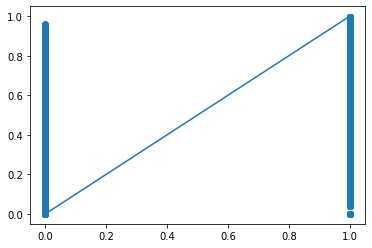

In [15]:
plt.plot(train[target], train[target])
plt.scatter(train[target], xgb_oof)

In [16]:
del train
del xgb_oof
gc.collect()

20

# Features importances

Text(0.5, 1.0, 'XGB feature importances')

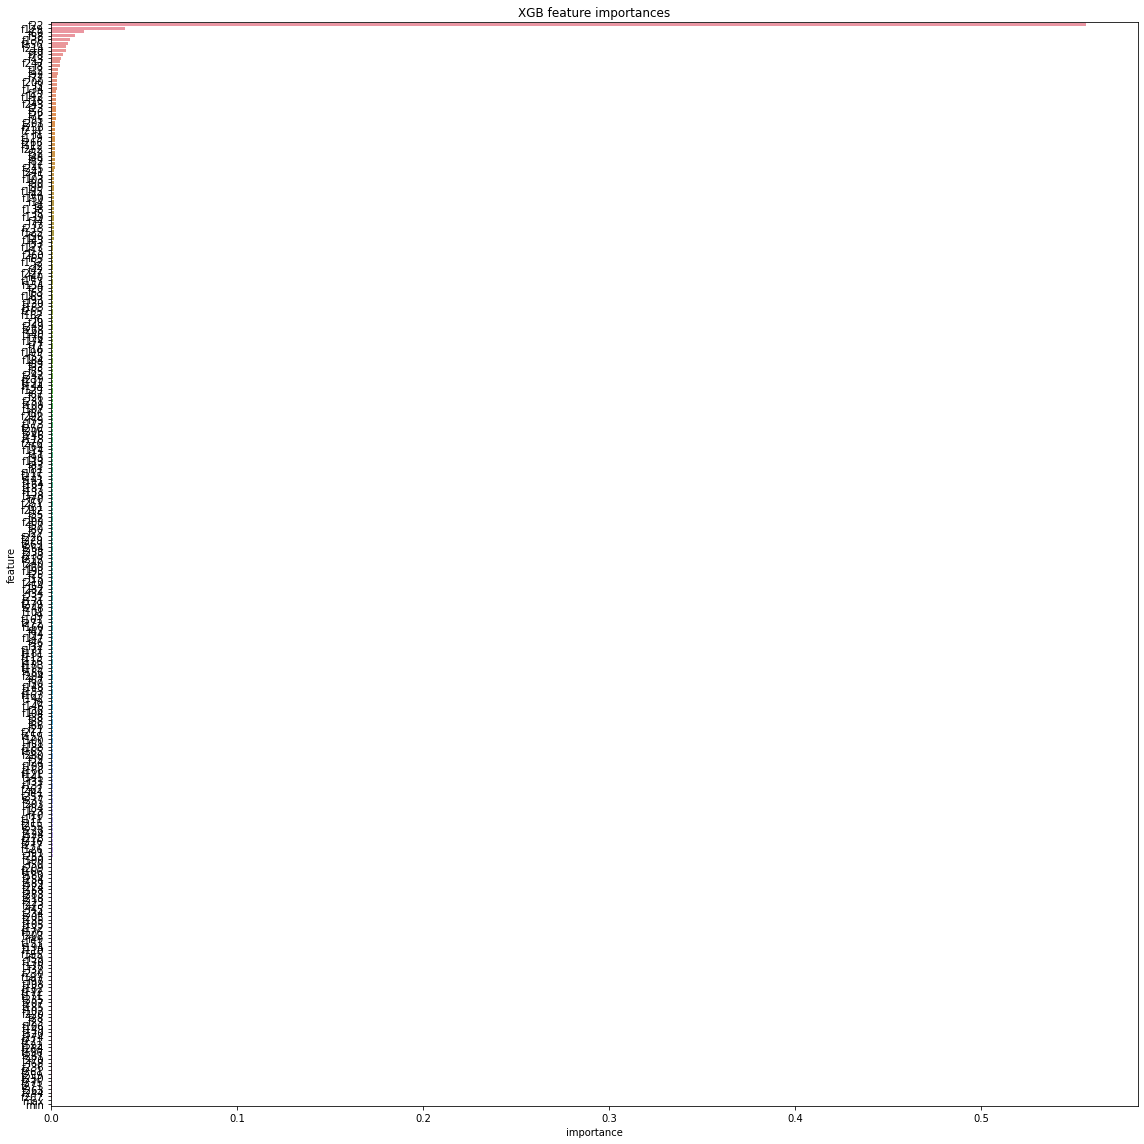

In [17]:
order = list(xgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=xgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("XGB feature importances")

# Submission

In [18]:
submission[target] = xgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,target
0,1000000,0.290983
1,1000001,0.093569
2,1000002,0.362340
3,1000003,0.332100
4,1000004,0.100851
...,...,...
499995,1499995,0.387286
499996,1499996,0.334252
499997,1499997,0.116791
499998,1499998,0.211168


# Log

seeds

2017 ver5 fold 0-2 ver6 fold 3-4

2018 ver7 fold 0-2 ver8 fold 3-4

2019 ver9 fold 0-2 ver10 fold 3-4

2020 ver11 fold 0-2 ver12 fold 3-4

2021 ver13 fold 0-2 ver14 fold 3-4